In [23]:
GRAPHS = {'inf-power':"data/inf-power/inf-power.mtx",
          'protein':"data/protein/bio-yeast-protein-inter.edges",
          'erdos':"data/erdos/ca-Erdos992.mtx",
         'auto_as19990309':"data/as19990309.txt",
          'auto_as19990111':"/data/as-733/as19990111.txt",
          'wiki':"data/wiki/soc-wiki-Vote.mtx",
         'norwegian': 'data/norwegian/net1m_2011-08-01.txt',
         'netscience':'data/dimacs10-netscience/out.dimacs10-netscience',
         'moreno_innovation':"data/moreno_innovation/out.moreno",
#          'inf_power':'data/inf-power/inf-power.mtx',
         'GrQc':'data/ca_GrQc/ca-GrQc.mtx',
         'auto_as19980318':'data/as19980318.txt',
         'auto_as19971108':'data/as19971108.txt',
         'tech_routers':'data/routers/tech-routers-rf.mtx',
         "ca_grq":"data/ca_GrQc/ca-GrQc.mtx",
         'oregon':"data/oregon_331/oregon1_010331.txt",
         'arena':"data/arenas-jazz/out.arenas-jazz",
#          'moreno_oz':"data/moreno_oz/out.moreno_oz_oz",
          'moreno_oz':"data/moreno_oz/out.moreno_oz_ozcsv",
         "hamsterer":"data/hamsterer/soc-hamsterster.edges",
          "openflights":"data/openflights/inf-openflights.edges",
          "tech_pgp":"data/pgp/tech-pgp.edges",
          'dmela':"data/dmela/bio-dmela.mtx",
          "whois":"data/WHOIS/tech-WHOIS.mtx",
          'webspam':"data/web-spam/web-spam.mtx",
          "gnutella08":"data/gnutalla08/p2p-Gnutella08.txt",
#           'notredame':"data/web-NotreDame.txt",
          'email_auall':"data/Email-EuAll.txt",
          'email_enron':"data/Email-Enron.txt",
          'musae_git':"data/git_web_ml/musae_git_edges.csv",
          'musae_facebook':"data/facebook_large/musae_facebook_edges.csv",
#           'fb_pages_artist':"data/fb-pages-artist/fb-pages-artist.edges",
#           'gowalla':"data/soc-gowalla/soc-gowalla.mtx",
#           'slashdot':"data/soc-slashdot/soc-slashdot.mtx",
          'ca-HepPh':'data/ca-HepPh.mtx', #+
          'karate':'data/karate.edglist'
         }

In [24]:
import networkx as nx
# graph = nx.read_adjlist(GRAPHS['oregon'])

In [25]:
def get_core_strengths(graph:nx.Graph, core_numbers):
    cs = dict()
    for node in graph:
        bn = [ x for x in graph.neighbors(node) if core_numbers[x]>=core_numbers[node]]
        cs[node] = len(bn) - core_numbers[node]+1
    return cs

In [26]:
def orig_edges(graph):
    kcores = nx.core_number(graph)
    cs = get_core_strengths(graph, kcores)
    ev = dict()
    for u,v in graph.edges():
        if kcores[u]!=kcores[v]:
            if kcores[u]>kcores[v]:
                u,v = v,u
            ev[frozenset([u,v])] = kcores[u]/len([n for n in graph.neighbors(u) if kcores[n]>=kcores[u]])
        else:
            ev[frozenset([u,v])] = (kcores[u]/len([n for n in graph.neighbors(u) if kcores[n]>=kcores[v]]))*kcores[v]/len([n for n in graph.neighbors(v) if kcores[n]>=kcores[v]])
        # k[u]<k[v]
    return ev

In [27]:
import numpy as np
import random
from scipy.optimize import fixed_point, root


def get_prob_needed_fixed(graph:nx.Graph, core_numbers):
    cs_strengths = get_core_strengths(graph, core_numbers)
    cs = dict()
    for node in graph:
#         bn = [ x for x in graph.neighbors(node) if core_numbers[x]>=core_numbers[node]]
        bn = [ x for x in graph.neighbors(node) if core_numbers[x]>core_numbers[node] or
              (core_numbers[x]==core_numbers[node] and cs_strengths[x]>1)]
        bn_diff = [ x for x in graph.neighbors(node) if core_numbers[x]==core_numbers[node] and cs_strengths[x]==1]
        if len(bn) == 0:
            cs[node] = 1
        else:
            cs[node] = max((core_numbers[node]-len(bn_diff))/len(bn),0)
    return cs


def hr_edges(graph):
    kcores = nx.core_number(graph)
    cs = get_core_strengths(graph, kcores)
    np, ps, gk = dict(), dict(), dict()
    edge_avg_cs = get_prob_needed_fixed(graph, kcores) #{frozenset(x):min(cs[x[0]],cs[x[1]]) for x in graph.edges()}
    edges_v = dict()
    for e in graph.edges():
        el = list(e)
        if kcores[e[0]]>kcores[e[1]]:
            edges_v[frozenset(e)] = edge_avg_cs[el[1]]
        elif kcores[e[0]]<kcores[e[1]]:
            edges_v[frozenset(e)] = edge_avg_cs[el[0]]
        else:
            edges_v[frozenset(e)] = max(edge_avg_cs[el[0]], edge_avg_cs[el[1]])
    return edges_v


def node_importance(T, A, A2, cs):
    return ((1-(cs/(A.dot((1-T).T)+A2.T+ cs)))-T)

def node_importance_adj(T, A, A2, cs, kkrs):
    cs_mask = cs==0
    cs_1 = cs.copy()
    cs_1[cs_mask] = 1
    cs_1[~cs_mask] = 0
    adj_prob = A2.T+A.dot(1-cs_1)-np.maximum(0, kkrs-A.T.dot(cs_1))
    return (1-(adj_prob/(A.dot((1-T).T)+A2.T+A.dot(1-cs_1)))-T)



def hr_edges_global(graph):
    kkrs = nx.core_number(graph)
    cs_strengths = np.array(list(get_core_strengths(graph, kkrs).values()))-1
    A = nx.adjacency_matrix(graph, nodelist = graph.nodes()).todense()
    kkrs_numpy = np.array(list(kkrs.values()))
    for i in range(len(A)):
        A[i,kkrs_numpy!=kkrs_numpy[i]] = 0
        
    A2 = nx.adjacency_matrix(graph, nodelist = graph.nodes()).todense()
    for i in range(len(A2)):
        A2[i,kkrs_numpy<=kkrs_numpy[i]] = 0
    A2 = A2.sum(axis=1)
    
    A_big = nx.adjacency_matrix(graph, nodelist = graph.nodes()).todense()
    for i in range(len(A_big)):
        A_big[i,kkrs_numpy<kkrs_numpy[i]] = 0  
    ni = root(node_importance, np.zeros(graph.number_of_nodes()), args=(A,A2,cs_strengths),
    method = 'df-sane', tol = 0.00000000000001)
    prb_needed = {n:float(ni.x[i]) for i,n in enumerate(graph.nodes())}
    edges_v = dict()
    for e in graph.edges():
        el = list(e)
        if kkrs[e[0]]>kkrs[e[1]]:
            edges_v[frozenset(e)] = prb_needed[el[1]]
        elif kkrs[e[0]]<kkrs[e[1]]:
            edges_v[frozenset(e)] = prb_needed[el[0]]
        else:
            edges_v[frozenset(e)] = max(prb_needed[el[0]], prb_needed[el[1]])
    return edges_v


In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def visualize_graph_CSS(graph, node_scale=0.5, savepath=None, label = None):
    figure(figsize=(6, 5), dpi=80)
    k_shells = nx.core_number(graph)
    edges_imp = orig_edges(graph)
    #sorted(list(set(k_shells.values())))
    ng_edges = dict()
    for u,v in graph.edges():
#         if k_shells[u]==25 or k_shells[v]==25:
#             print(u,v, k_shells[u],k_shells[v] )
        try:
            ng_edges[frozenset([k_shells[u],k_shells[v]])] += edges_imp[frozenset([u,v])]
        except Exception as inst:
            ng_edges[frozenset([k_shells[u],k_shells[v]])] = edges_imp[frozenset([u,v])]
    
    new_graph = nx.Graph()
    
    nds_size = {k:0 for k in sorted(list(set(k_shells.values())))}
    weights_heur = dict()
    for j in sorted(list(set(k_shells.values())), reverse=True):
        new_graph.add_node(j)
        s = 0 # sum of weight of all edges with at least one endpoint in j-shell
        for i in sorted(list(set(k_shells.values()))): # if edge to the higher k-core
            s+=ng_edges.get(frozenset([i,j]),0)
        for i in sorted(list(set(k_shells.values()))):
            if j<=i:
                if frozenset([i,j]) in ng_edges:
                    new_graph.add_edge(j,i, weight=ng_edges[frozenset([i,j])]/s)
                    weights_heur[frozenset([i,j])] = ng_edges[frozenset([i,j])]/s
            if i<j:
                nds_size[j]+= ng_edges.get(frozenset([i,j]),0)
    H = nx.Graph()
    H.add_nodes_from(sorted(new_graph.nodes(data=True), reverse=True))
    H.add_edges_from(new_graph.edges(data=True))
    nds_size_list = [nds_size[v]*node_scale for v in sorted(list(set(k_shells.values())), reverse=True)]
    pos = nx.circular_layout(H)
    pos = {k:list(reversed(v)) for k,v in pos.items()}
    nx.draw_networkx_nodes(H, pos=pos, node_color='green', node_size=nds_size_list)#,  with_labels=True, edge_color='green', node_color='green')
    nx.draw_networkx_labels(H, pos=pos)
    el = list(H.edges(data='weight'))
    nx.draw_networkx_edges(H, pos, edgelist=el, width=[e[2]*4 for e in el], edge_color='green')
#     for edge in tqdm(H.edges(data='weight')):
#         if edge[0]!=edge[1] and edge[2]!=0:
#             wdth = edge[2]*4
#             nx.draw_networkx_edges(H, pos, edgelist=[edge], width=wdth, edge_color='green')
    if label is not None:
        plt.title(label)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()
    return weights_heur

In [30]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def visualize_graph(graph, node_scale=0.5, local=True, savepath = None, label = None):
    figure(figsize=(6, 5), dpi=80)
    k_shells = nx.core_number(graph)
    if local:
        edges_imp = hr_edges(graph)
    else:
        edges_imp = hr_edges_global(graph)
    #sorted(list(set(k_shells.values())))
    ng_edges = dict()
    for u,v in graph.edges():
#         if k_shells[u]==25 or k_shells[v]==25:
#             print(u,v, k_shells[u],k_shells[v] )
        try:
            ng_edges[frozenset([k_shells[u],k_shells[v]])] += edges_imp[frozenset([u,v])]
        except Exception as inst:
            ng_edges[frozenset([k_shells[u],k_shells[v]])] = edges_imp[frozenset([u,v])]
    
    new_graph = nx.Graph()
    
    nds_size = {k:0 for k in sorted(list(set(k_shells.values())))}
    weights_heur = dict()
    for j in sorted(list(set(k_shells.values())), reverse=True):
        new_graph.add_node(j)
        s = 0 # sum of weight of all edges with at least one endpoint in j-shell
        for i in sorted(list(set(k_shells.values()))): # if edge to the higher k-core
            s+=ng_edges.get(frozenset([i,j]),0)
        for i in sorted(list(set(k_shells.values()))):
            if j<=i:
                if frozenset([i,j]) in ng_edges:
                    if s!=0:
                        new_graph.add_edge(j,i, weight=ng_edges[frozenset([i,j])]/s)
                        weights_heur[frozenset([i,j])] = ng_edges[frozenset([i,j])]/s
#                     else:
#                         new_graph.add_edge(j,i, weight=1)
            if i<j:
                nds_size[j]+= ng_edges.get(frozenset([i,j]),0)
    H = nx.Graph()
    H.add_nodes_from(sorted(new_graph.nodes(data=True), reverse=True))
    H.add_edges_from(new_graph.edges(data=True))
    nds_size_list = [nds_size[v]*node_scale for v in sorted(list(set(k_shells.values())), reverse=True)]
    pos = nx.circular_layout(H)
    pos = {k:list(reversed(v)) for k,v in pos.items()}
    nx.draw_networkx_nodes(H, pos=pos, node_color='green', node_size=nds_size_list)#,  with_labels=True, edge_color='green', node_color='green')
    nx.draw_networkx_labels(H, pos=pos)
    el = list(H.edges(data='weight'))
    nx.draw_networkx_edges(H, pos, edgelist=el, width=[e[2]*4 for e in el], edge_color='green')
#     for edge in tqdm(H.edges(data='weight')):
#         if edge[0]!=edge[1] and edge[2]!=0:
#             wdth = edge[2]*4
#             nx.draw_networkx_edges(H, pos, edgelist=[edge], width=wdth, edge_color='green')
    if label is not None:
        plt.title(label)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()
    return weights_heur

In [35]:
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import os

graph_names = ["moreno_innovation",'norwegian','protein', 'netscience']#,'tech_routers']
files = []
for graph_name in graph_names:
    files_loc = ["paper_samples/{}/{}".format(graph_name,x) for x in os.listdir('paper_samples/{}/'.format(graph_name))]
    files.extend(files_loc)

# data_list = []
# for file in tqdm(files):
#     with open('{}'.format(file),'rb') as f:
#         data_list.append(pickle.load(f)) 
        


In [36]:
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import os
\
        

In [37]:
data_list = []
for file in tqdm(files):
    with open('{}'.format(file),'rb') as f:
        data_list.append(pickle.load(f)) 

df = pd.DataFrame()
df['orig_filename'] = files
df['data'] = data_list
df['filename'] = df['orig_filename'].apply(lambda x:x.split('/')[-1])
df

  0%|          | 0/6000 [00:00<?, ?it/s]

orig_filename  \
0       paper_samples/moreno_innovation/0.1_38.history   
1     paper_samples/moreno_innovation/0.05_196.history   
2     paper_samples/moreno_innovation/0.05_129.history   
3     paper_samples/moreno_innovation/0.05_107.history   
4     paper_samples/moreno_innovation/0.05_131.history   
...                                                ...   
5995         paper_samples/netscience/0.03_190.history   
5996          paper_samples/netscience/0.1_101.history   
5997           paper_samples/netscience/1.0_36.history   
5998         paper_samples/netscience/0.01_190.history   
5999          paper_samples/netscience/0.05_50.history   

                                                   data          filename  
0     (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...    0.1_38.history  
1     (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_196.history  
2     (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_129.history  
3     (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_107.history  
4     (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_131.history  
...                                                 ...               ...  
5995  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.03_190.history  
5996  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   0.1_101.history  
5997  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...    1.0_36.history  
5998  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.01_190.history  
5999  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   0.05_50.history  

[6000 rows x 3 columns]

In [38]:
df['fname'] = df['filename'].apply(lambda x:float(x.split('_')[0]))
df['#'] = df['filename'].apply(lambda x:int(x.replace('.history','').split('_')[1]))
df.head()

orig_filename  \
0    paper_samples/moreno_innovation/0.1_38.history   
1  paper_samples/moreno_innovation/0.05_196.history   
2  paper_samples/moreno_innovation/0.05_129.history   
3  paper_samples/moreno_innovation/0.05_107.history   
4  paper_samples/moreno_innovation/0.05_131.history   

                                                data          filename  fname  \
0  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...    0.1_38.history   0.10   
1  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_196.history   0.05   
2  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_129.history   0.05   
3  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_107.history   0.05   
4  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_131.history   0.05   

     #  
0   38  
1  196  
2  129  
3  107  
4  131

In [39]:
df['edges_num'] = df['data'].apply(lambda x:x.number_of_edges())
df.head()

orig_filename  \
0    paper_samples/moreno_innovation/0.1_38.history   
1  paper_samples/moreno_innovation/0.05_196.history   
2  paper_samples/moreno_innovation/0.05_129.history   
3  paper_samples/moreno_innovation/0.05_107.history   
4  paper_samples/moreno_innovation/0.05_131.history   

                                                data          filename  fname  \
0  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...    0.1_38.history   0.10   
1  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_196.history   0.05   
2  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_129.history   0.05   
3  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_107.history   0.05   
4  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_131.history   0.05   

     #  edges_num  
0   38        746  
1  196        751  
2  129        751  
3  107        748  
4  131        743

In [40]:
df['orig_graph'] = df['orig_filename'].apply(lambda x:x.split('/')[1])
df.head()

orig_filename  \
0    paper_samples/moreno_innovation/0.1_38.history   
1  paper_samples/moreno_innovation/0.05_196.history   
2  paper_samples/moreno_innovation/0.05_129.history   
3  paper_samples/moreno_innovation/0.05_107.history   
4  paper_samples/moreno_innovation/0.05_131.history   

                                                data          filename  fname  \
0  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...    0.1_38.history   0.10   
1  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_196.history   0.05   
2  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_129.history   0.05   
3  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_107.history   0.05   
4  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.05_131.history   0.05   

     #  edges_num         orig_graph  
0   38        746  moreno_innovation  
1  196        751  moreno_innovation  
2  129        751  moreno_innovation  
3  107        748  moreno_innovation  
4  131        743  moreno_innovation

In [41]:
def edges_stats(graph, graph_name, df):
    df_temp = df[(df['orig_graph']==graph_name) & (df['fname']==df['fname'].max())]
    edict = {frozenset(e):0 for e in graph.edges()}
    for sk in df_temp['data'].values:
        for e in sk.edges():
            edict[frozenset(e)]+=1/len(df_temp)
    return edict

def visualize_graph_ground_truth(graph, df, graph_name, node_scale=0.5, savepath = None, label = None):
    if graph_name not in set(df['orig_graph']):
        raise Exception("Unknown graph")
    figure(figsize=(6, 5), dpi=80)
    k_shells = nx.core_number(graph)
    edges_imp = edges_stats(graph, graph_name, df)
    #sorted(list(set(k_shells.values())))
    ng_edges = dict()
    for u,v in graph.edges():
#         if k_shells[u]==25 or k_shells[v]==25:
#             print(u,v, k_shells[u],k_shells[v] )
        try:
            ng_edges[frozenset([k_shells[u],k_shells[v]])] += edges_imp[frozenset([u,v])]
        except Exception as inst:
            ng_edges[frozenset([k_shells[u],k_shells[v]])] = edges_imp[frozenset([u,v])]
    
    new_graph = nx.Graph()
    
    nds_size = {k:0 for k in sorted(list(set(k_shells.values())))}
    weights_true = dict()
    for j in sorted(list(set(k_shells.values())), reverse=True):
        new_graph.add_node(j)
        s = 0 # sum of weight of all edges with at least one endpoint in j-shell
        for i in sorted(list(set(k_shells.values()))): # if edge to the higher k-core
            s+=ng_edges.get(frozenset([i,j]),0)
        for i in sorted(list(set(k_shells.values()))):
            if j<=i:
                if frozenset([i,j]) in ng_edges:
                    if s!=0:
                        new_graph.add_edge(j,i, weight=ng_edges[frozenset([i,j])]/s)
                        weights_true[frozenset([i,j])] = ng_edges[frozenset([i,j])]/s
#                     else:
#                         new_graph.add_edge(j,i, weight=1)
            if i<j:
                nds_size[j]+= ng_edges.get(frozenset([i,j]),0)
    H = nx.Graph()
    H.add_nodes_from(sorted(new_graph.nodes(data=True), reverse=True))
    
    H.add_edges_from(new_graph.edges(data=True))
    nds_size_list = [nds_size[v]*node_scale for v in sorted(list(set(k_shells.values())), reverse=True)]
    pos = nx.circular_layout(H)
    pos = {k:list(reversed(v)) for k,v in pos.items()}
    nx.draw_networkx_nodes(H, pos=pos, node_color='green', node_size=nds_size_list)#,  with_labels=True, edge_color='green', node_color='green')
    nx.draw_networkx_labels(H, pos=pos)
    el = list(H.edges(data='weight'))
    
    nx.draw_networkx_edges(H, pos, edgelist=el, width=[e[2]*4 for e in el], edge_color='green')
#     for edge in tqdm(H.edges(data='weight')):
#         if edge[0]!=edge[1] and edge[2]!=0:
#             wdth = edge[2]*4
#             nx.draw_networkx_edges(H, pos, edgelist=[edge], width=wdth, edge_color='green')
    if label is not None:
        plt.title(label)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()
    return weights_true

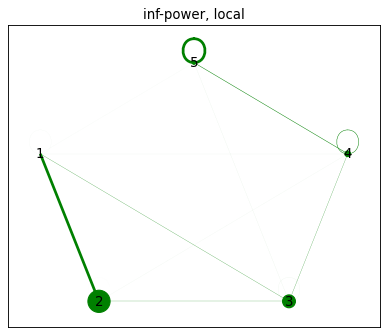

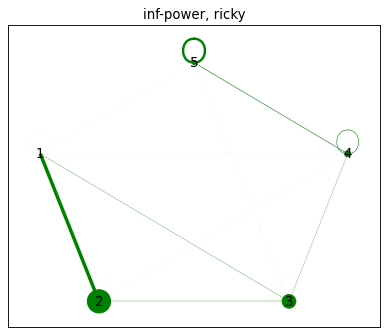

0.23365106822581513 0 0.2130465748326843 0


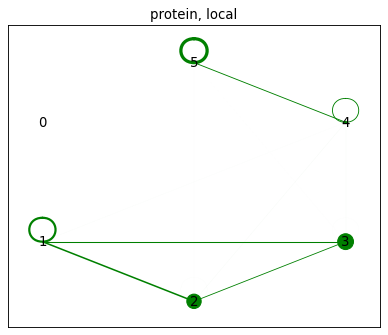

0.24599417266544116 0 0.2284944517649102 0.247631155481637


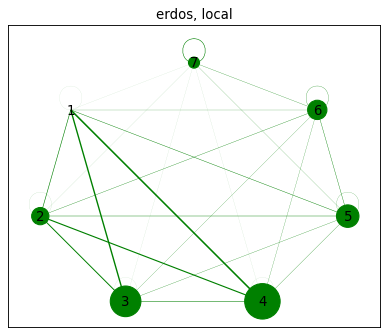

0.10289925069189412 0 0.09729735220254863 0


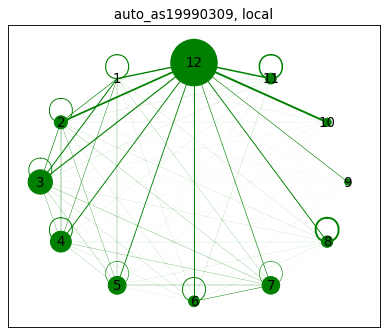

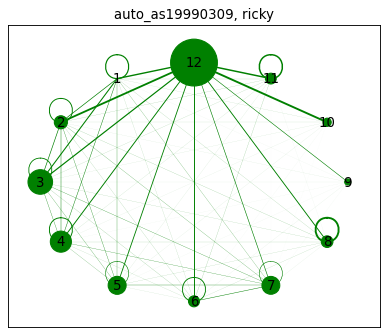

0.07191336752281287 0 0.07051818373519479 0


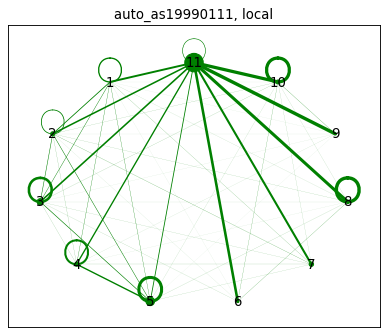

0.1321509431680146 0 0.12995060232705943 0


0.13157321449066703 0 0.12746122609897587 0


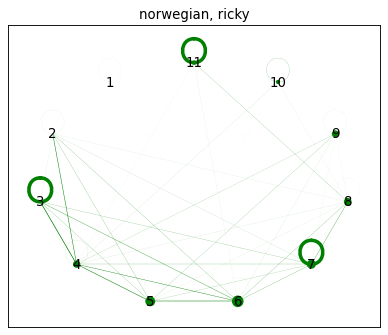

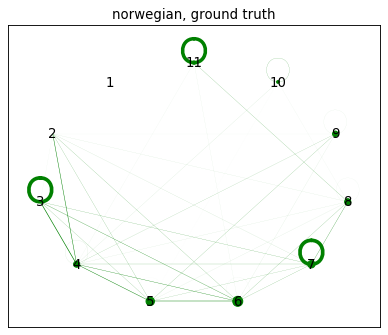

0.22328945426136504 0 0.21918828996840958 0.22333995908801996


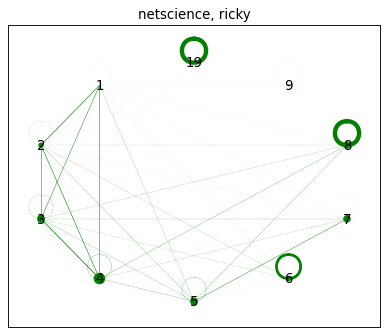

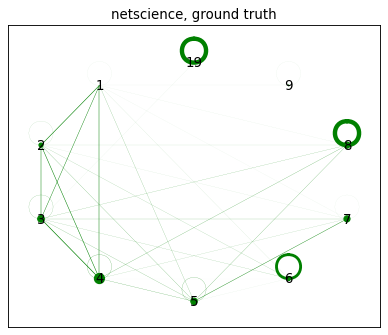

0.2286024426464004 0 0.22518447196223368 0.22864129106442727


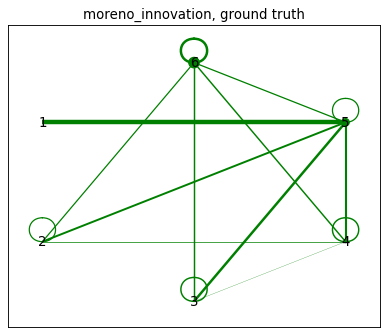

0.35456653780134617 0 0.3444295573159511 0.35374312332413643


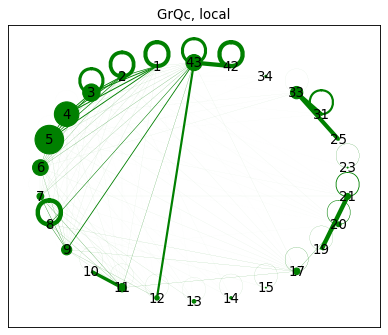

0.1425224933123478 0 0.13984804617743893 0


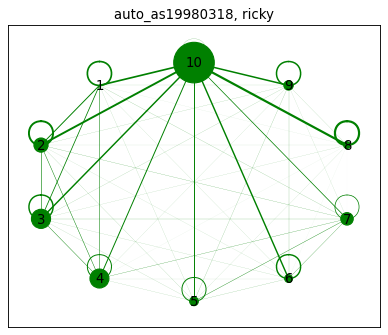

0.09017161899001644 0 0.08796945695929899 0


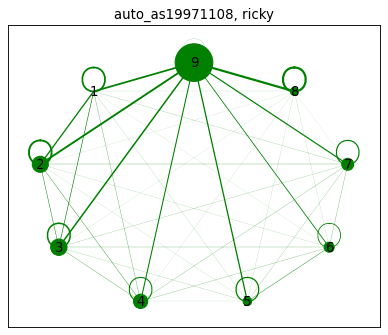

0.10086162336700016 0 0.09821567902051077 0


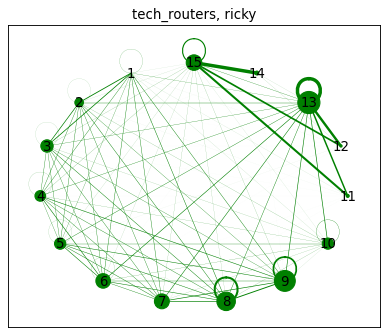

0.09571537243808302 0 0.09206976034953561 0


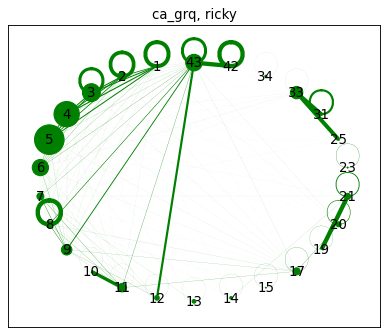

0.1425224933123478 0 0.13984804617743893 0


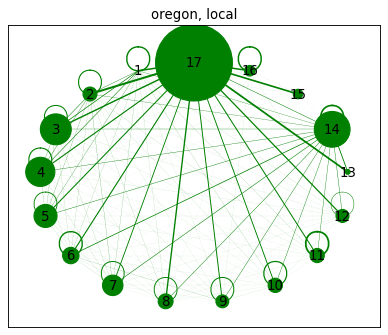

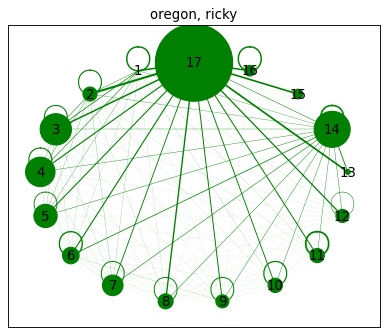

0.05601749481023184 0 0.0551972916312461 0


0.16419252085789343 0 0.1624461863048951 0


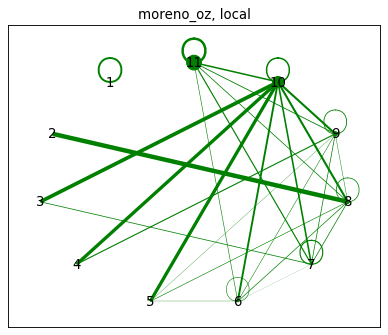

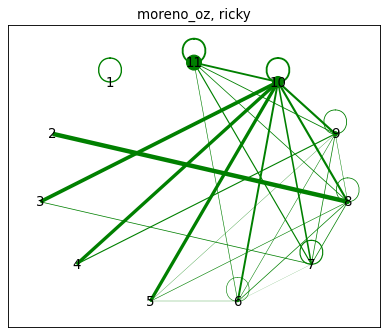

0.3202519784650233 0 0.31402232270143454 0


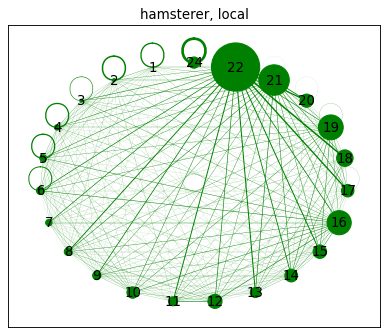

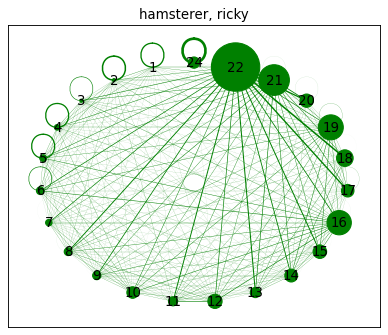

0.06260271748768748 0 0.061781614646824044 0


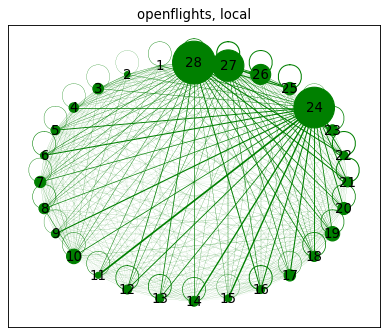

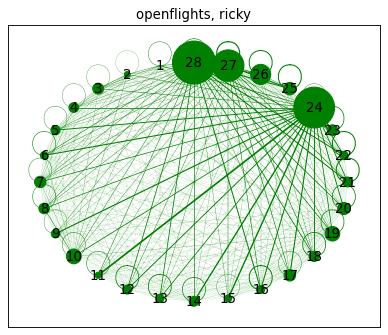

0.04682635844409556 0 0.04630245985719512 0


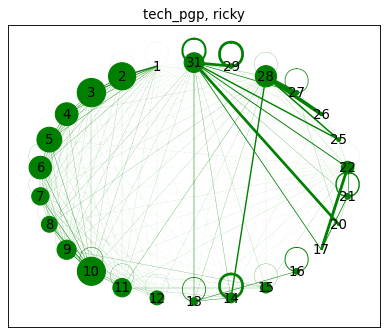

0.0694295535745693 0 0.06639959248128327 0


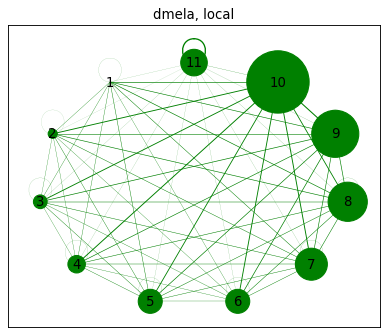

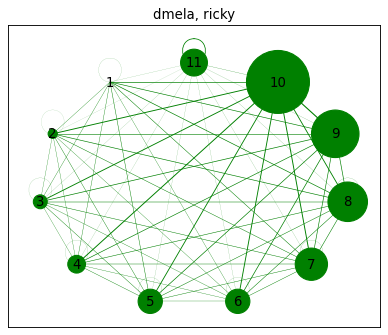

0.10633661089066798 0 0.10241914433572151 0


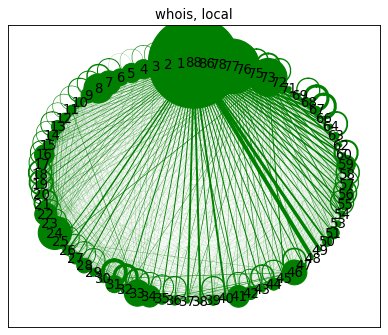

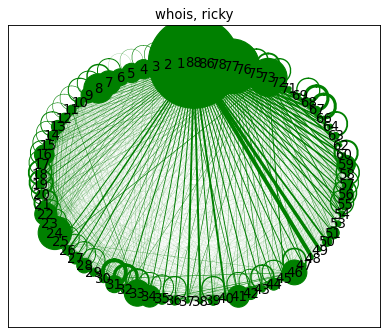

0.028040172171578705 0 0.02779099173382228 0


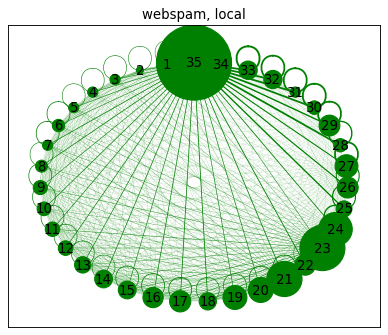

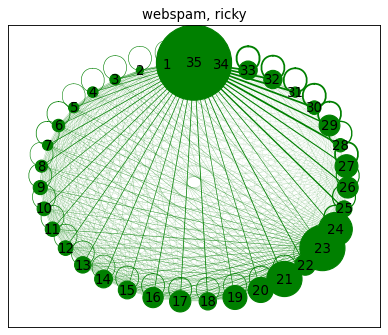

0.035110164475583946 0 0.034768260757960974 0


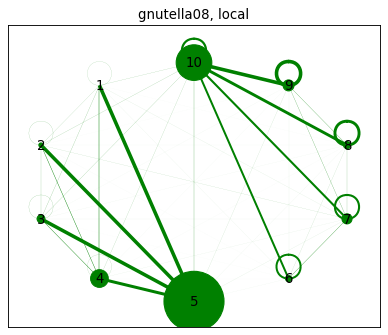

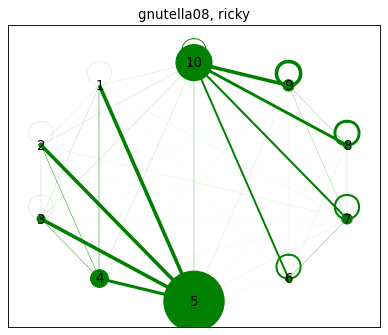

0.13516338634419486 0 0.12655688706946028 0


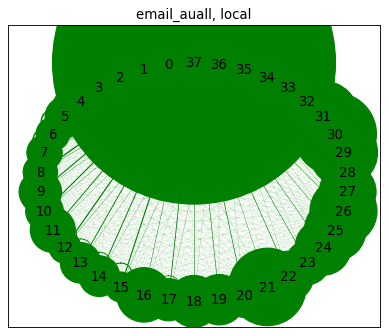

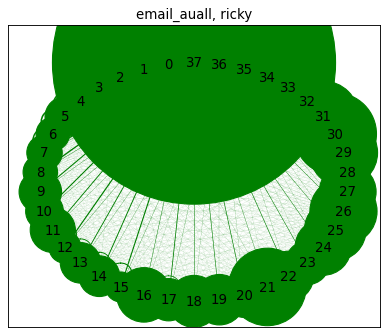

0.02042295019267932 0 0.020360976387875967 0


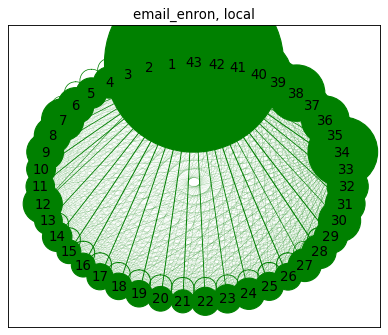

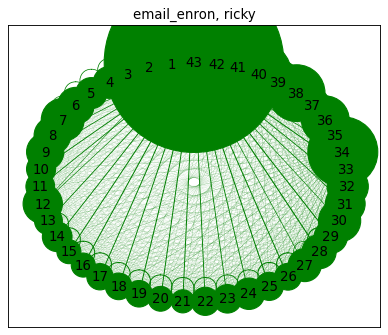

0.027784245883146798 0 0.027570044964713644 0


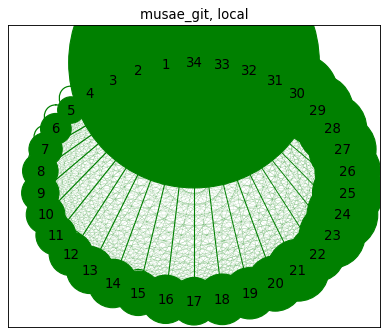

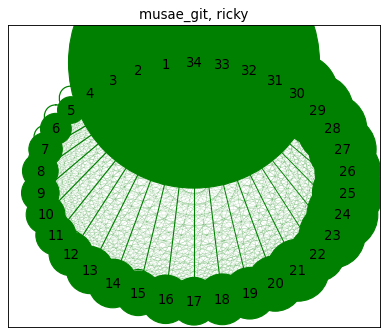

0.035975073460694174 0 0.03582234254234022 0


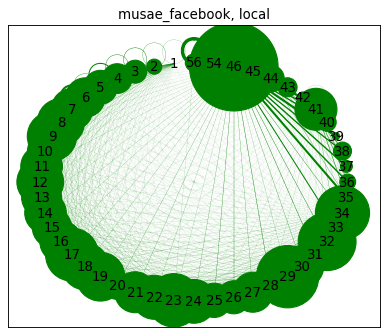

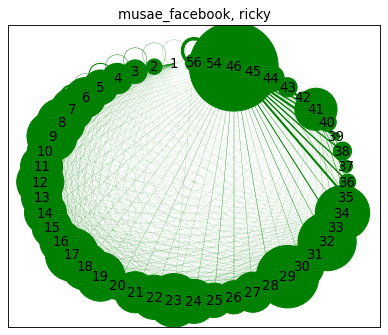

0.02639947498775325 0 0.025718805806947975 0


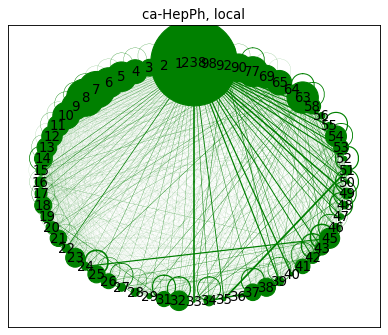

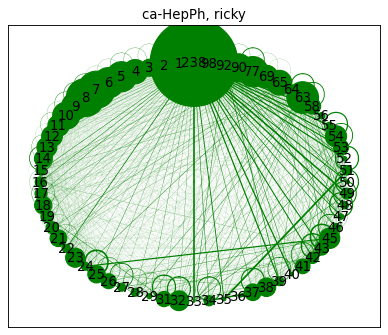

0.031066643405905127 0 0.03071200926742308 0


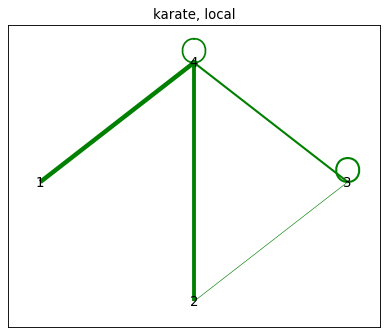

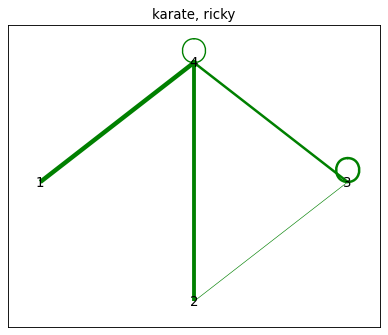

0.5468367456876535 0 0.5336942160121005 0


In [42]:

import numpy as np

stats_sum = dict()
# for gr_name in ['norwegian','moreno_oz','arena','moreno_innovation','GrQc','netscience']:
# for gr_name in ['norwegian','moreno_oz','arena','moreno_innovation','GrQc','netscience',"erdos",'inf-power','protein','auto_as19990309','auto_as19990111','auto_as19980318','auto_as19971108','wiki','karate']:
for gr_name in GRAPHS.keys():
# for gr_name in ['moreno_oz']:
# gr_name = 'moreno_oz'
    graph = nx.read_edgelist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))
    lc = visualize_graph(graph, savepath = 'heuristics_plots_decentr/{}_local.png'.format(gr_name),label="{}, local".format(gr_name))    
    rk = visualize_graph_CSS(graph, savepath = 'heuristics_plots_decentr/{}_css.png'.format(gr_name), label="{}, css".format(gr_name))
    gtrthv = 0
    try:
        gtrth = visualize_graph_ground_truth(graph,df, gr_name, savepath = 'heuristics_plots_decentr/{}_truth.png'.format(gr_name),label="{}, ground truth".format(gr_name))
        gtrthv = np.mean(list(gtrth.values()))
    except:
        pass
    lcv = np.mean(list(lc.values()))
    glv = 0 #np.mean(list(gl.values()))
    rkv = np.mean(list(rk.values()))
    try:
        print(lcv, glv,rkv, gtrthv)
        if gr_name!='arena':
            stats_sum[gr_name] = (lcv, glv,rkv, gtrthv)
    except:
        print(lcv, glv ,rkv)

In [43]:
import pandas as pd

stats_sum2 = {k:v for k,v in stats_sum.items() if v[3]!=0}
stats_sum_df = pd.DataFrame.from_dict(stats_sum2).T
stats_sum_df = stats_sum_df.dropna()
stats_sum_df.columns = ['local','global', 'CSS','ground_truth']
stats_sum_df.to_csv('heuristics_plotting_comparison2.csv')
stats_sum_df[['local','CSS','ground_truth']]

local       CSS  ground_truth
protein            0.245994  0.228494      0.247631
norwegian          0.223289  0.219188      0.223340
netscience         0.228602  0.225184      0.228641
moreno_innovation  0.354567  0.344430      0.353743

In [44]:
stats_sum_df['local']-stats_sum_df['CSS']

protein              0.017500
norwegian            0.004101
netscience           0.003418
moreno_innovation    0.010137
dtype: float64

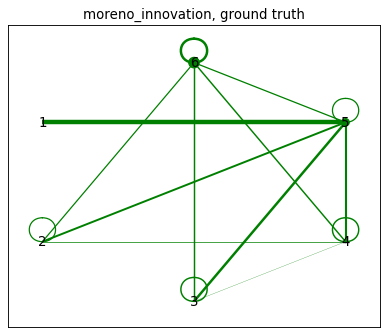

In [45]:
for gr_name in ['moreno_innovation']:
    graph = nx.read_adjlist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))

    visualize_graph_ground_truth(graph,df, gr_name, savepath = 'heuristics_plots_decentr/{}_truth.png'.format(gr_name),label="{}, ground truth".format(gr_name))
    

In [46]:
# density of the potential skeletal k-core
# higher density of the k-core means higher fragility of the graph at that region
# how to visualize?
# assortativity of the ``fragility''?
# collapse as supernodes? But what should be supernode? K-shell? 
# how we even define subgraphs? they should be dynamic, that's for sure. 
# measure of variance of this density? We define it on the edges;
# what if we merge edges in "superedges"? 
#Or if we have two nodes with high edge with high probability of presense in k-core, we could merge them.
# spectral clustering! and compare with usual clustering, without weights
# also, are there any motifs that could be used?
# transportations networks?

In [47]:
# def vis_weird(graph):
#     e_imp = hr_edges(graph)
#     merge_nodes_dict = []
#     for e, imp in e_imp.items():
        

In [69]:
from scipy.stats.stats import pearsonr 
import matplotlib
import scipy 

def visualize_edges(graph, df, graph_name, axs):
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    ground_truth = edges_stats(graph, graph_name, df)
    edges_local = hr_edges(graph)
    edges_global = hr_edges_global(graph)
    edges_css = orig_edges(graph)
#     figure(figsize=(24, 10))
#     figure(figsize=(24, 5))
    ordered = list(ground_truth.items())
    x = [v for k,v in ordered]
    y_css = [edges_css[e] for e,v in ordered]
    y_local = [edges_local[e] for e,v in ordered]
    y_global = [edges_global[e] for e,v in ordered]
#     fig, axs = plt.subplots(1,2,figsize=(12, 4))
#     print(graph_name,,'\r\n'*2, np.corrcoef(x, y_local),'\r\n'*2, np.corrcoef(x, y_global))

    axs[0].scatter(x, y_css)
    axs[0].set_title("{}, CSS heuristics".format(graph_name), size=16)
    axs[0].text(.05, .9, 'corr={:.3f}'.format(scipy.stats.pearsonr(x, y_css)[0]), transform=axs[0].transAxes, size=16)
    axs[1].set_title("{}, $\\rho$-heuristics".format(graph_name), size=16)
    axs[1].text(.05, .9, 'corr={:.3f}'.format(scipy.stats.pearsonr(x, y_local)[0]), transform=axs[1].transAxes, size=16)
    axs[1].scatter(x, y_local)


[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]
[<AxesSubplot:> <AxesSubplot:>]


/home/anaconda3/envs/skeletal/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


[<AxesSubplot:> <AxesSubplot:>]
[<AxesSubplot:> <AxesSubplot:>]
[<AxesSubplot:> <AxesSubplot:>]


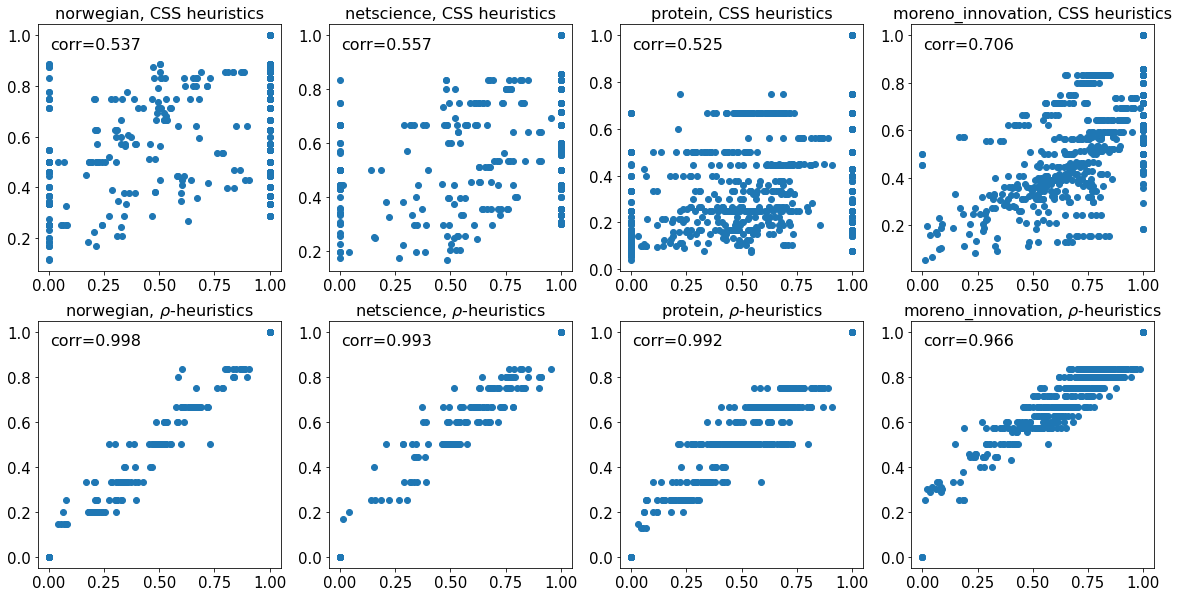

In [71]:
# list of interesting - norwegian, moreno_innovation,
g_list = ['norwegian','netscience','protein','moreno_innovation']
fig, axs = plt.subplots(int(len(g_list)/2),4, figsize=(20, 10))
# print(axs)
print(axs)
# axs = np.array(axs).reshape(-1,2)
axs = np.array(axs).T.reshape(-1,2)#.flatten().reshape(-1,2)
# print(axs.shape)
for i, gr_name in enumerate(g_list):#,'arena','moreno_innovation','GrQc','netscience','moreno_oz',"erdos",'inf-power']:
# for gr_name in ['moreno_oz']:
# gr_name = 'moreno_oz'
    print(axs[i])
    graph = nx.read_adjlist(GRAPHS[gr_name])
    graph.remove_edges_from(nx.selfloop_edges(graph))
    visualize_edges(graph,df, gr_name, axs[i])
plt.savefig("paper_plots/heuristics_vs_truth.png", bbox_inches='tight')
plt.show()